In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary

from tqdm.notebook import tqdm

### **Loading Data**

In [ ]:
# Define transformations
transform = transforms.Compose([
  transforms.ToTensor(),  # Convert data to tensors
])

# Load MNIST dataset with normalization
train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 192785388.18it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 61646663.52it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74348434.71it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 11552776.69it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



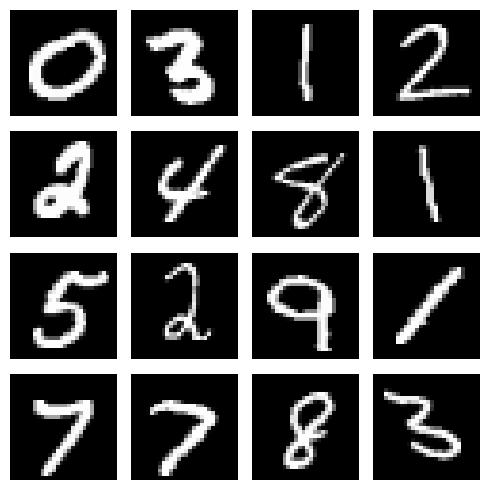

In [ ]:
# Get a batch of images from the data loader
images, _ = next(iter(train_loader))

# Convert images to NumPy arrays for Matplotlib
images = images.numpy()

# Plot some images in a grid
num_images = 16  # Adjust as needed
plt.figure(figsize=(5, 5))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

## GAN

In [ ]:
channels = 1
img_size = 28
img_shape = (channels, img_size, img_size)
latent_dim = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = True if torch.cuda.is_available() else False # GPU Setting

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256, normalize = False),
            nn.Linear(256, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 256), # (28*28, 512)
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid() # result : from 0 to 1
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
adversarial_loss = torch.nn.BCELoss()

In [ ]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [ ]:
summary(generator, (latent_dim,))
summary(discriminator, img_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           8,320
         LeakyReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 256]          33,024
         LeakyReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 784]         201,488
              Tanh-6                  [-1, 784]               0
Total params: 242,832
Trainable params: 242,832
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.93
Estimated Total Size (MB): 0.94
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1

In [ ]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Epoch 1/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 1/100] [Batch: 938/938] [D loss: 0.2819] [G loss: 3.0570]

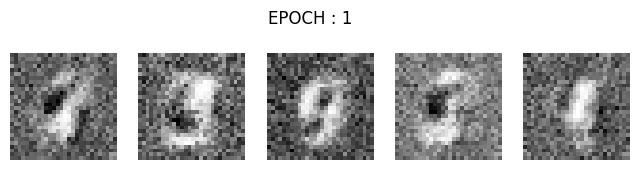

Epoch 2/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 2/100] [Batch: 938/938] [D loss: 0.3174] [G loss: 3.5645]

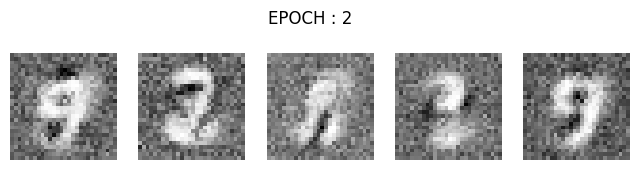

Epoch 3/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 3/100] [Batch: 938/938] [D loss: 0.2499] [G loss: 3.0815]

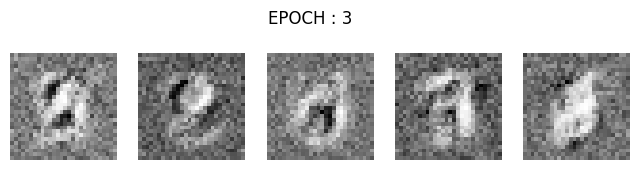

Epoch 4/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 4/100] [Batch: 938/938] [D loss: 0.1215] [G loss: 3.6109]

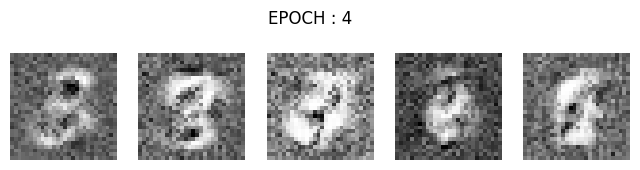

Epoch 5/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 5/100] [Batch: 938/938] [D loss: 0.3346] [G loss: 2.2294]

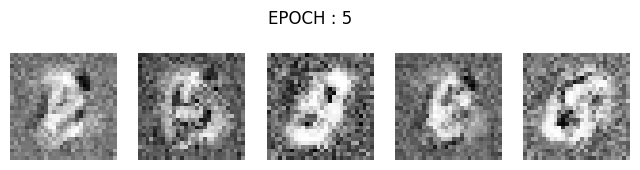

Epoch 6/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 6/100] [Batch: 938/938] [D loss: 0.4927] [G loss: 3.3327]

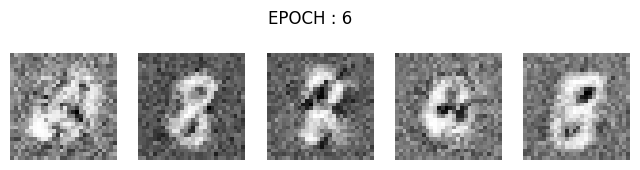

Epoch 7/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 7/100] [Batch: 938/938] [D loss: 0.2957] [G loss: 4.6895]

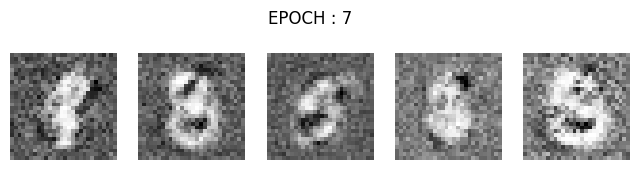

Epoch 8/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 8/100] [Batch: 938/938] [D loss: 0.2469] [G loss: 3.1206]

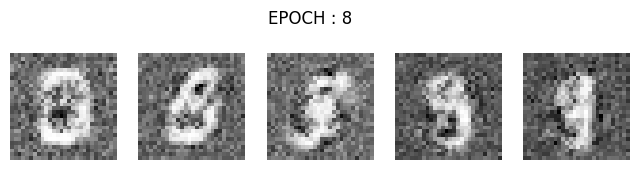

Epoch 9/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 9/100] [Batch: 938/938] [D loss: 0.4308] [G loss: 5.6559]

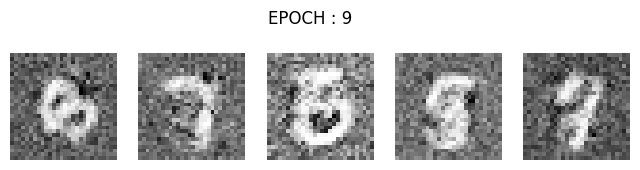

Epoch 10/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 10/100] [Batch: 938/938] [D loss: 0.3610] [G loss: 3.5092]

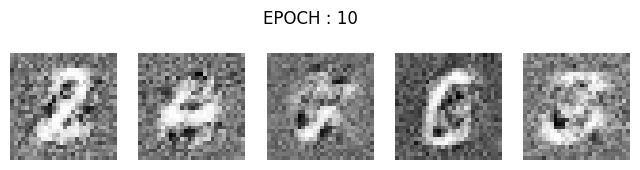

Epoch 11/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 11/100] [Batch: 938/938] [D loss: 0.2491] [G loss: 3.7209]

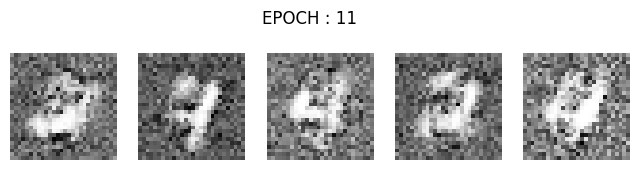

Epoch 12/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 12/100] [Batch: 938/938] [D loss: 0.2311] [G loss: 3.3466]

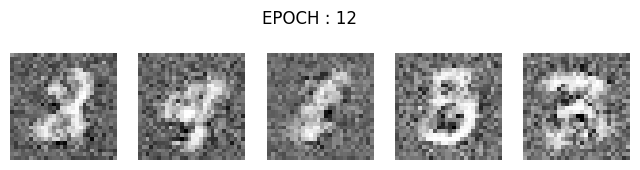

Epoch 13/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 13/100] [Batch: 938/938] [D loss: 0.2242] [G loss: 4.1012]

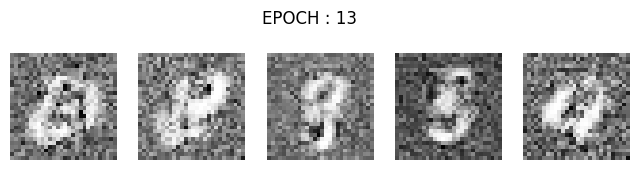

Epoch 14/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 14/100] [Batch: 938/938] [D loss: 0.2530] [G loss: 4.5939]

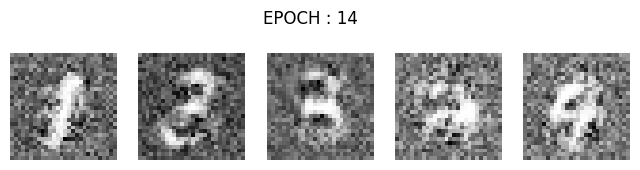

Epoch 15/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 15/100] [Batch: 938/938] [D loss: 0.1703] [G loss: 4.5780]

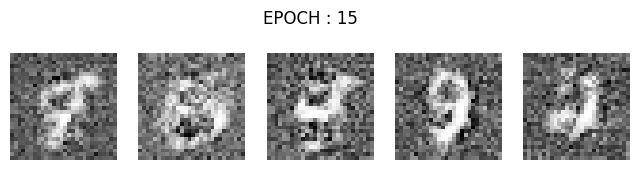

Epoch 16/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 16/100] [Batch: 938/938] [D loss: 0.3377] [G loss: 3.0969]

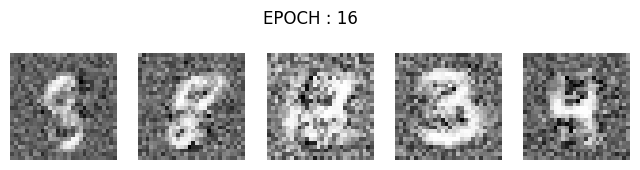

Epoch 17/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 17/100] [Batch: 938/938] [D loss: 0.2736] [G loss: 3.8419]

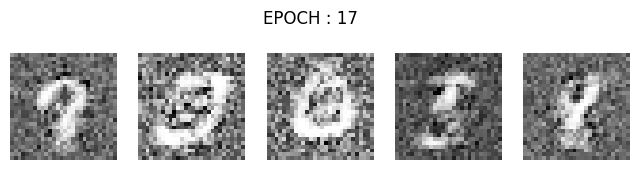

Epoch 18/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 18/100] [Batch: 938/938] [D loss: 0.3648] [G loss: 3.5695]

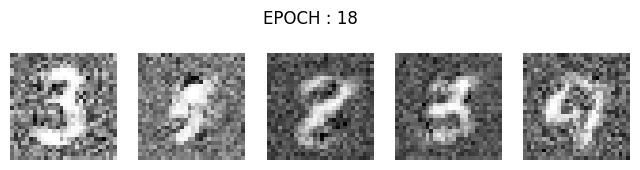

Epoch 19/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 19/100] [Batch: 938/938] [D loss: 0.3691] [G loss: 3.6201]

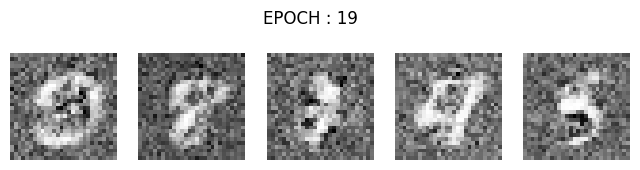

Epoch 20/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 20/100] [Batch: 938/938] [D loss: 0.4283] [G loss: 2.6162]

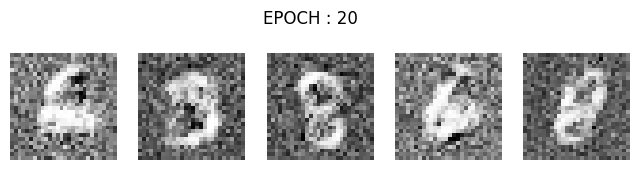

Epoch 21/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 21/100] [Batch: 938/938] [D loss: 0.2394] [G loss: 4.4124]

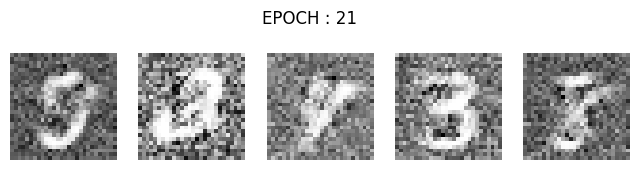

Epoch 22/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 22/100] [Batch: 938/938] [D loss: 0.2171] [G loss: 3.7957]

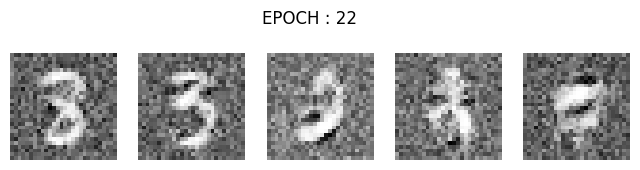

Epoch 23/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 23/100] [Batch: 938/938] [D loss: 0.1673] [G loss: 4.3238]

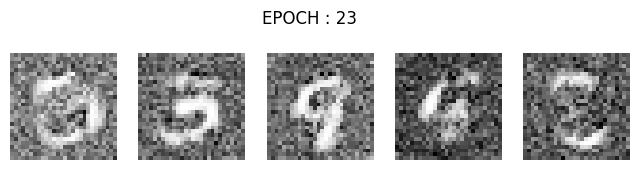

Epoch 24/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 24/100] [Batch: 938/938] [D loss: 0.1882] [G loss: 4.1212]

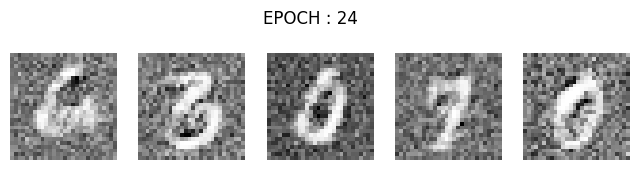

Epoch 25/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 25/100] [Batch: 938/938] [D loss: 0.1498] [G loss: 4.3611]

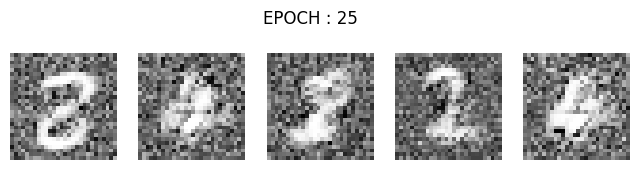

Epoch 26/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 26/100] [Batch: 938/938] [D loss: 0.1973] [G loss: 4.3853]

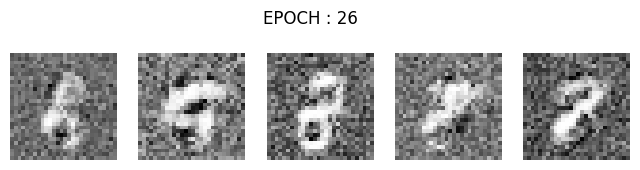

Epoch 27/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 27/100] [Batch: 938/938] [D loss: 0.1509] [G loss: 4.6873]

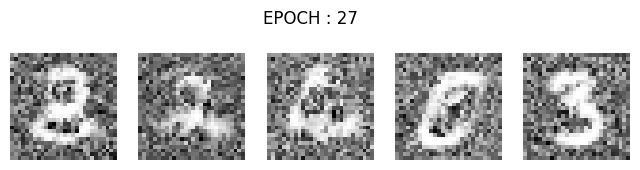

Epoch 28/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 28/100] [Batch: 938/938] [D loss: 0.1146] [G loss: 3.7912]

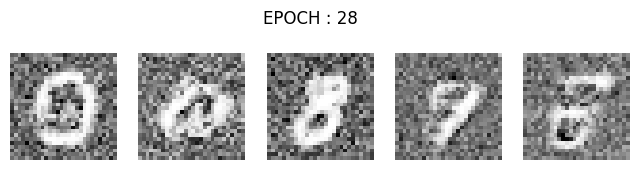

Epoch 29/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 29/100] [Batch: 938/938] [D loss: 0.1907] [G loss: 3.1586]

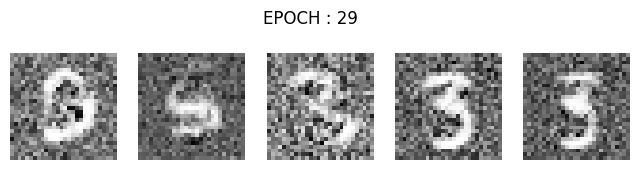

Epoch 30/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 30/100] [Batch: 938/938] [D loss: 0.2000] [G loss: 3.9137]

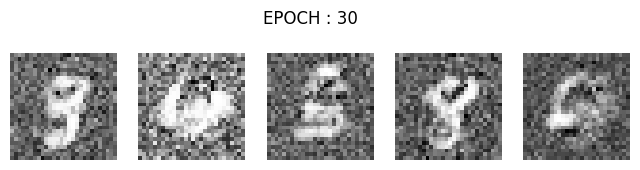

Epoch 31/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 31/100] [Batch: 938/938] [D loss: 0.1915] [G loss: 4.1278]

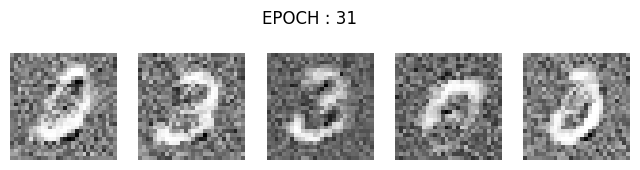

Epoch 32/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 32/100] [Batch: 938/938] [D loss: 0.1194] [G loss: 4.8675]

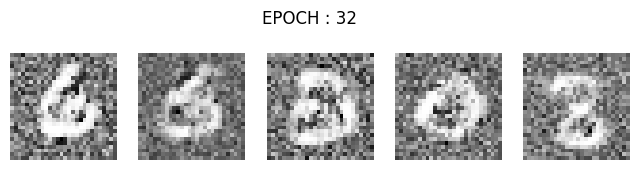

Epoch 33/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 33/100] [Batch: 938/938] [D loss: 0.1899] [G loss: 5.3056]

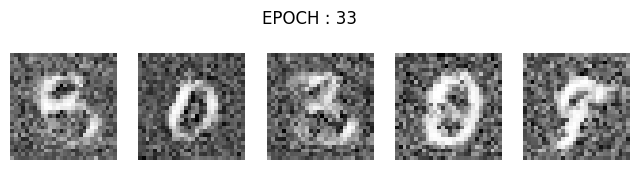

Epoch 34/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 34/100] [Batch: 938/938] [D loss: 0.2533] [G loss: 3.4095]

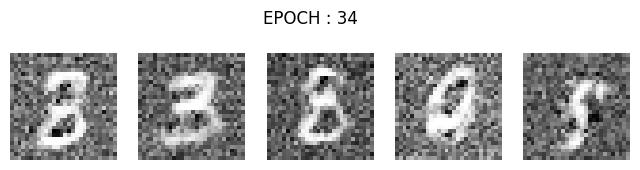

Epoch 35/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 35/100] [Batch: 938/938] [D loss: 0.3102] [G loss: 2.2404]

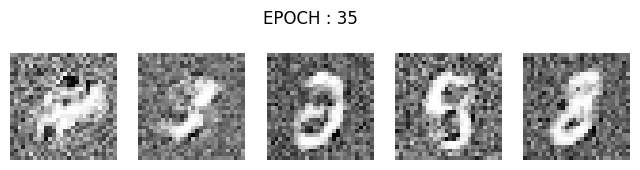

Epoch 36/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 36/100] [Batch: 938/938] [D loss: 0.2396] [G loss: 2.1849]

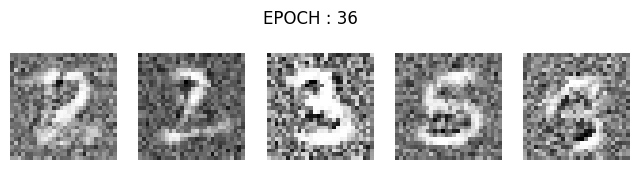

Epoch 37/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 37/100] [Batch: 938/938] [D loss: 0.1026] [G loss: 5.0805]

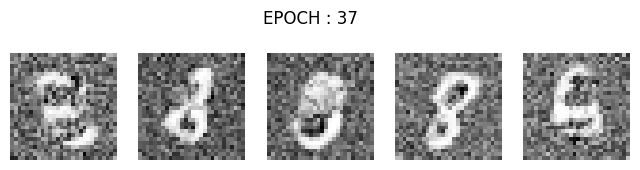

Epoch 38/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 38/100] [Batch: 938/938] [D loss: 0.2272] [G loss: 5.3435]

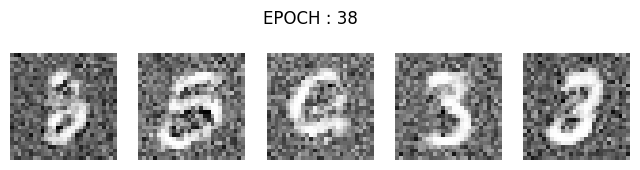

Epoch 39/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 39/100] [Batch: 938/938] [D loss: 0.2325] [G loss: 5.1836]

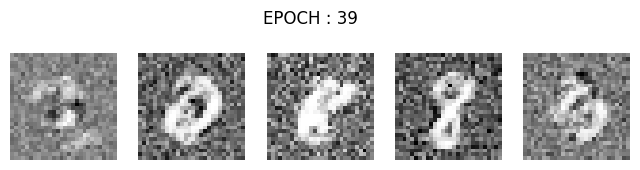

Epoch 40/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 40/100] [Batch: 938/938] [D loss: 0.1875] [G loss: 5.6665]

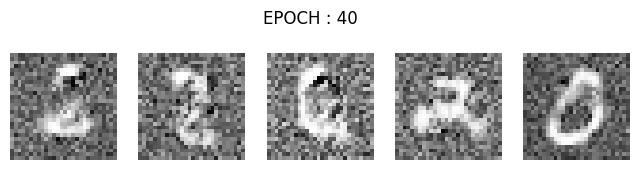

Epoch 41/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 41/100] [Batch: 938/938] [D loss: 0.1173] [G loss: 4.2673]

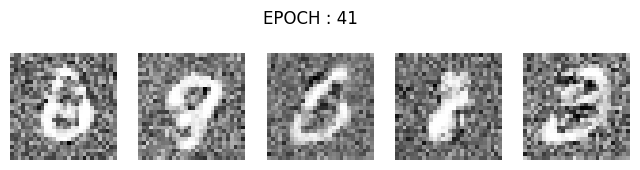

Epoch 42/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 42/100] [Batch: 938/938] [D loss: 0.1021] [G loss: 4.6683]

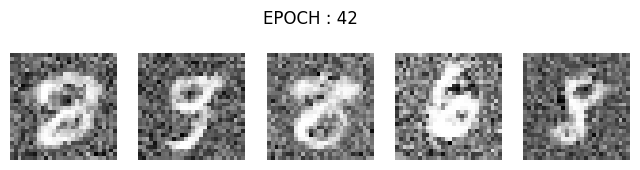

Epoch 43/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 43/100] [Batch: 938/938] [D loss: 0.4490] [G loss: 7.0317]

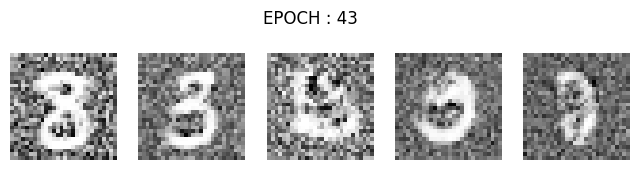

Epoch 44/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 44/100] [Batch: 938/938] [D loss: 0.1750] [G loss: 4.8621]

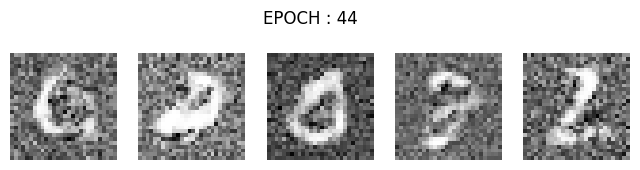

Epoch 45/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 45/100] [Batch: 938/938] [D loss: 0.2314] [G loss: 4.3603]

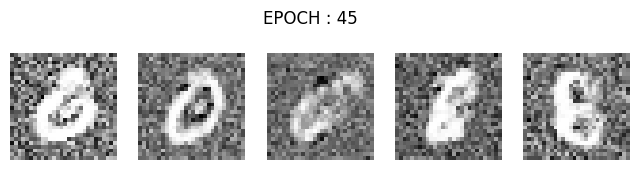

Epoch 46/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 46/100] [Batch: 938/938] [D loss: 0.1135] [G loss: 4.6283]

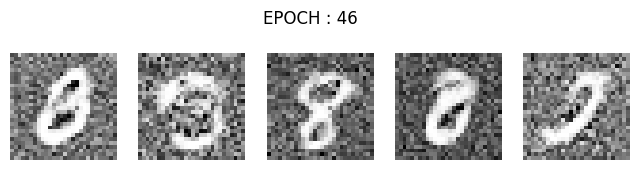

Epoch 47/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 47/100] [Batch: 938/938] [D loss: 0.1354] [G loss: 4.3227]

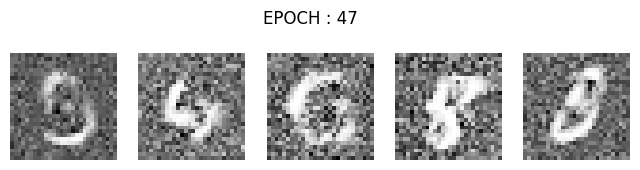

Epoch 48/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 48/100] [Batch: 938/938] [D loss: 0.2159] [G loss: 3.8334]

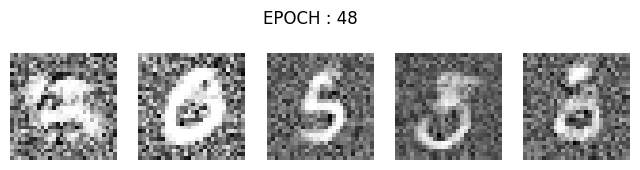

Epoch 49/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 49/100] [Batch: 938/938] [D loss: 0.1443] [G loss: 3.7445]

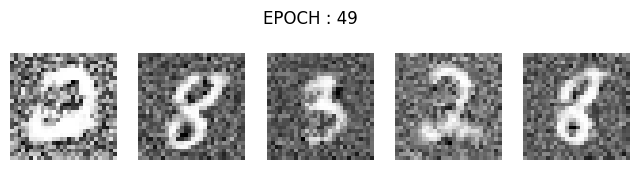

Epoch 50/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 50/100] [Batch: 938/938] [D loss: 0.2047] [G loss: 2.8369]

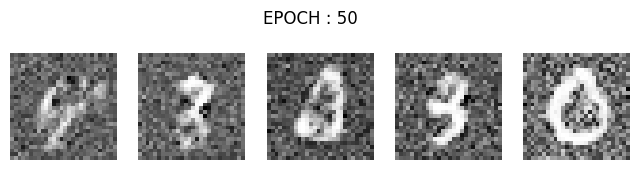

Epoch 51/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 51/100] [Batch: 938/938] [D loss: 0.1236] [G loss: 4.7222]

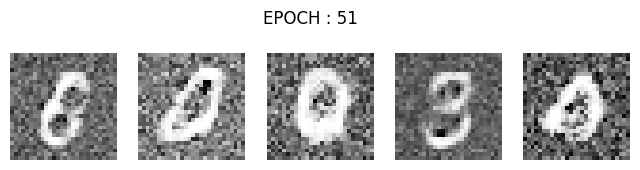

Epoch 52/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 52/100] [Batch: 938/938] [D loss: 0.1331] [G loss: 3.8322]

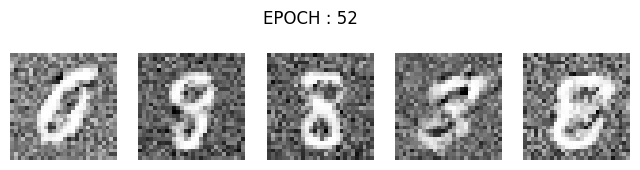

Epoch 53/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 53/100] [Batch: 938/938] [D loss: 0.1325] [G loss: 5.4862]

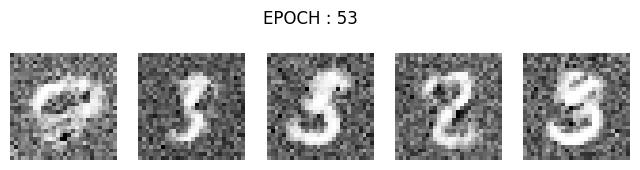

Epoch 54/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 54/100] [Batch: 938/938] [D loss: 0.1215] [G loss: 5.4047]

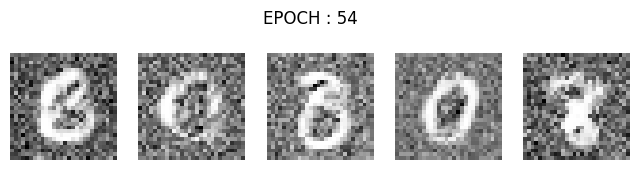

Epoch 55/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 55/100] [Batch: 938/938] [D loss: 0.0976] [G loss: 4.3319]

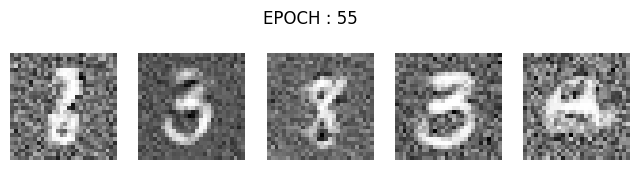

Epoch 56/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 56/100] [Batch: 938/938] [D loss: 0.1504] [G loss: 5.1134]

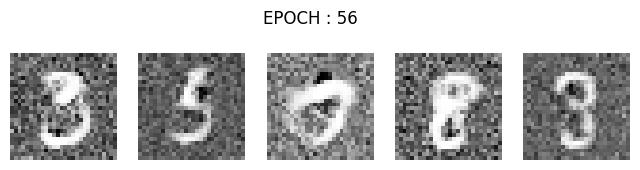

Epoch 57/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 57/100] [Batch: 938/938] [D loss: 0.2550] [G loss: 2.7790]

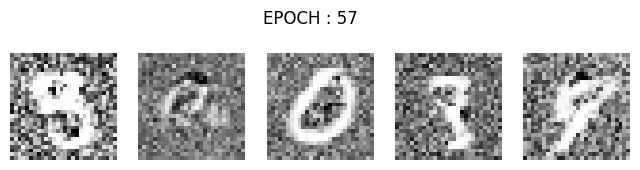

Epoch 58/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 58/100] [Batch: 938/938] [D loss: 0.1006] [G loss: 3.7050]

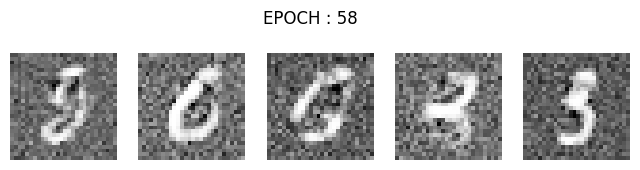

Epoch 59/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 59/100] [Batch: 938/938] [D loss: 0.1441] [G loss: 4.5152]

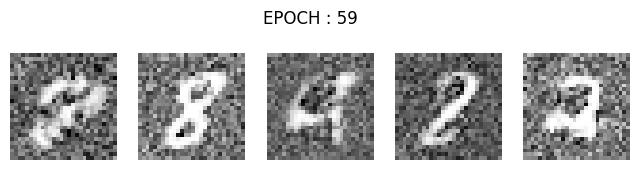

Epoch 60/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 60/100] [Batch: 938/938] [D loss: 0.3332] [G loss: 3.5381]

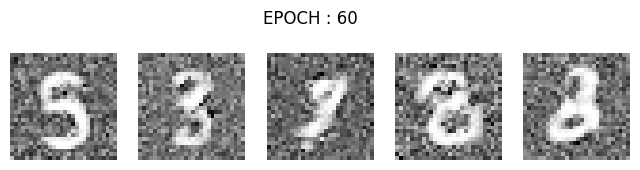

Epoch 61/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 61/100] [Batch: 938/938] [D loss: 0.1460] [G loss: 3.9986]

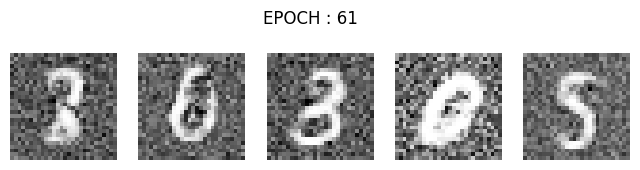

Epoch 62/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 62/100] [Batch: 938/938] [D loss: 0.2287] [G loss: 4.2572]

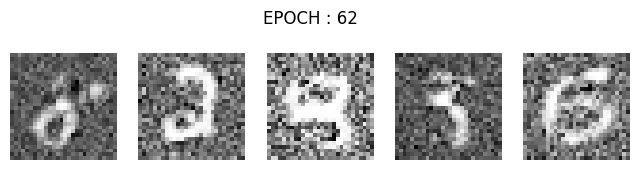

Epoch 63/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 63/100] [Batch: 938/938] [D loss: 0.3168] [G loss: 7.7482]

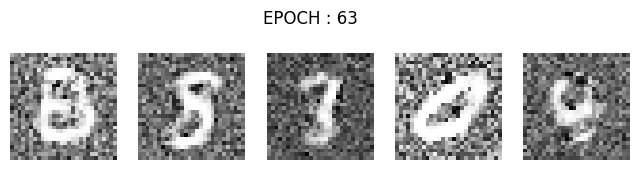

Epoch 64/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 64/100] [Batch: 938/938] [D loss: 0.1900] [G loss: 4.0951]

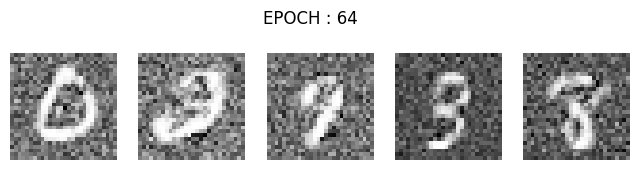

Epoch 65/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 65/100] [Batch: 938/938] [D loss: 0.2305] [G loss: 4.2145]

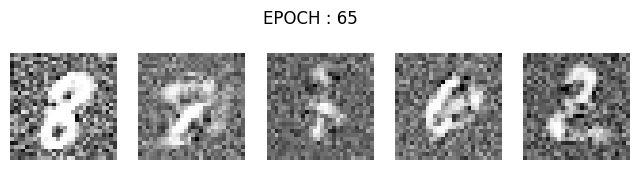

Epoch 66/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 66/100] [Batch: 938/938] [D loss: 0.1350] [G loss: 5.0012]

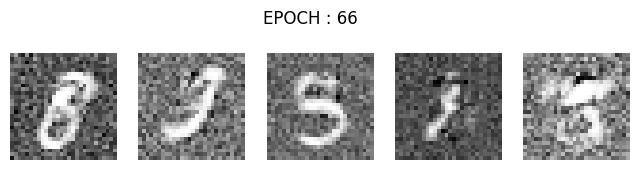

Epoch 67/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 67/100] [Batch: 938/938] [D loss: 0.1605] [G loss: 4.5509]

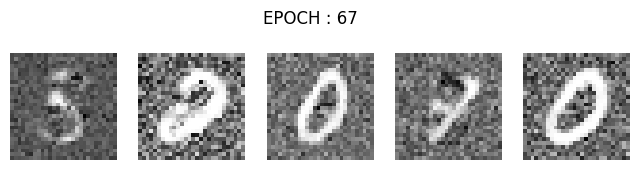

Epoch 68/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 68/100] [Batch: 938/938] [D loss: 0.3241] [G loss: 3.0521]

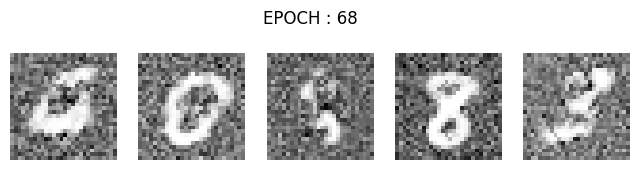

Epoch 69/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 69/100] [Batch: 938/938] [D loss: 0.0666] [G loss: 5.8036]

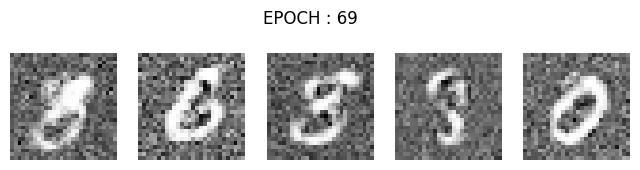

Epoch 70/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 70/100] [Batch: 938/938] [D loss: 0.1116] [G loss: 5.8513]

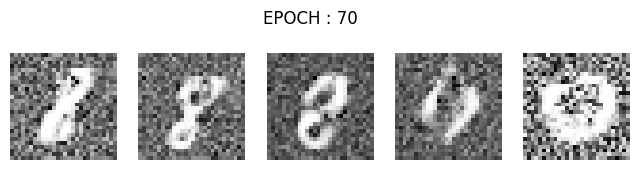

Epoch 71/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 71/100] [Batch: 938/938] [D loss: 0.1152] [G loss: 3.3050]

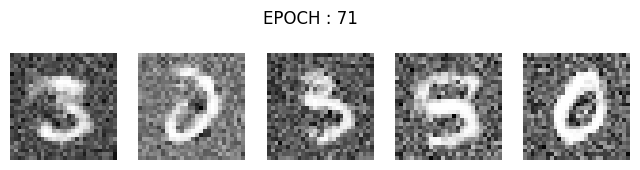

Epoch 72/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 72/100] [Batch: 938/938] [D loss: 0.0996] [G loss: 4.5813]

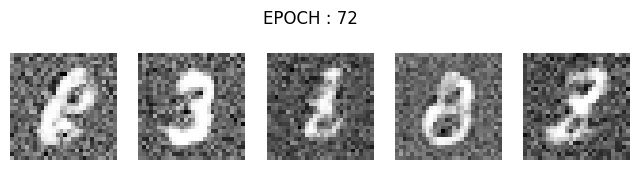

Epoch 73/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 73/100] [Batch: 938/938] [D loss: 0.2294] [G loss: 2.7421]

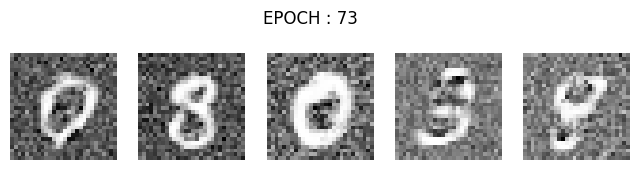

Epoch 74/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 74/100] [Batch: 938/938] [D loss: 0.0877] [G loss: 5.3822]

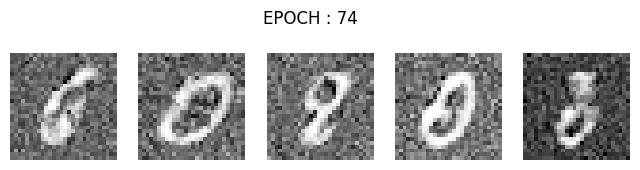

Epoch 75/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 75/100] [Batch: 938/938] [D loss: 0.1255] [G loss: 5.2784]

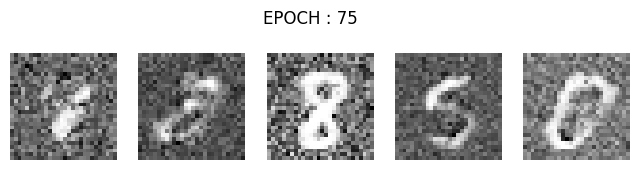

Epoch 76/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 76/100] [Batch: 938/938] [D loss: 0.1280] [G loss: 4.7544]

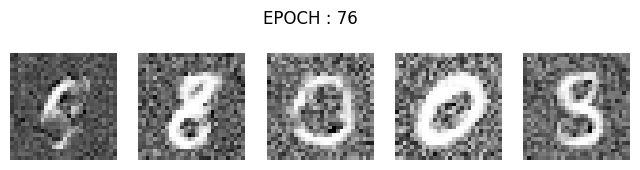

Epoch 77/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 77/100] [Batch: 938/938] [D loss: 0.1989] [G loss: 6.1907]

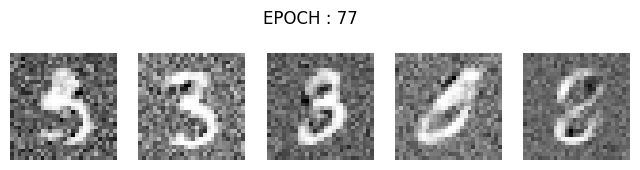

Epoch 78/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 78/100] [Batch: 938/938] [D loss: 0.1082] [G loss: 4.8272]

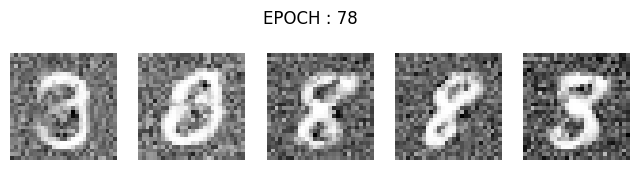

Epoch 79/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 79/100] [Batch: 938/938] [D loss: 0.1416] [G loss: 4.8893]

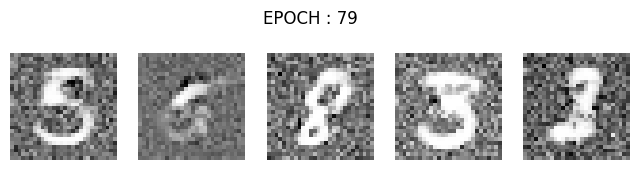

Epoch 80/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 80/100] [Batch: 938/938] [D loss: 0.1390] [G loss: 5.0813]

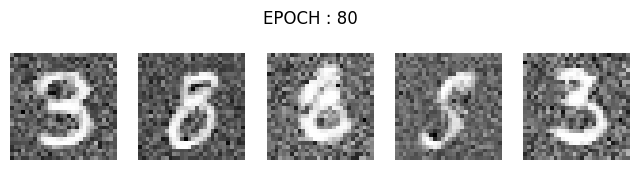

Epoch 81/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 81/100] [Batch: 938/938] [D loss: 0.2135] [G loss: 4.5618]

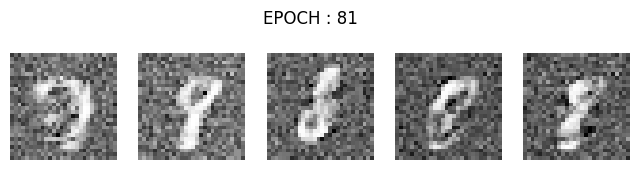

Epoch 82/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 82/100] [Batch: 938/938] [D loss: 0.1026] [G loss: 3.6944]

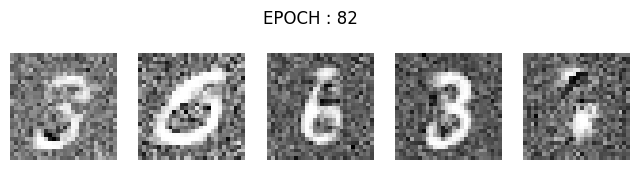

Epoch 83/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 83/100] [Batch: 938/938] [D loss: 0.1304] [G loss: 5.0015]

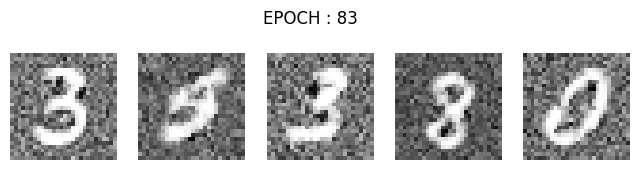

Epoch 84/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 84/100] [Batch: 938/938] [D loss: 0.1358] [G loss: 3.8578]

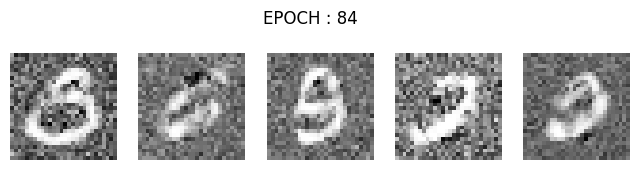

Epoch 85/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 85/100] [Batch: 938/938] [D loss: 0.1166] [G loss: 5.7099]

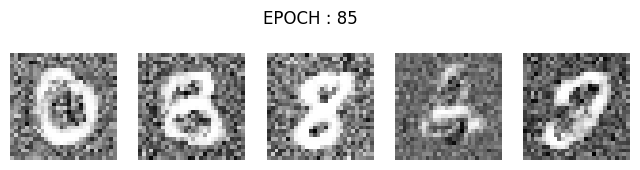

Epoch 86/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 86/100] [Batch: 938/938] [D loss: 0.0670] [G loss: 5.7648]

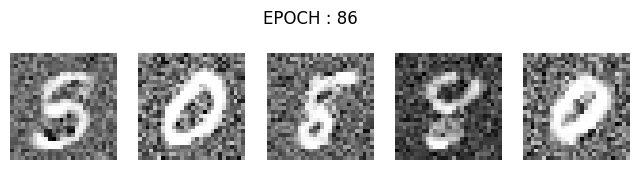

Epoch 87/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 87/100] [Batch: 938/938] [D loss: 0.1854] [G loss: 4.2205]

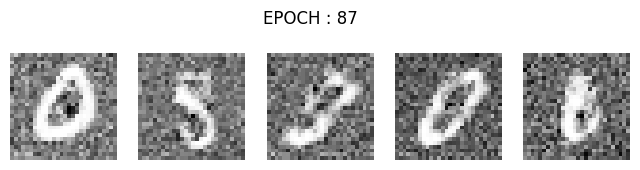

Epoch 88/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 88/100] [Batch: 938/938] [D loss: 0.1811] [G loss: 4.4363]

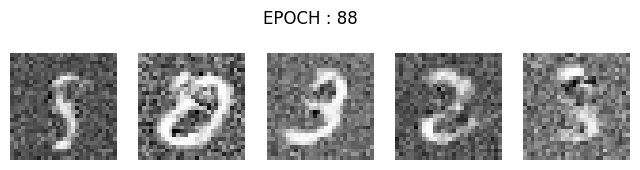

Epoch 89/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 89/100] [Batch: 938/938] [D loss: 0.1546] [G loss: 3.9059]

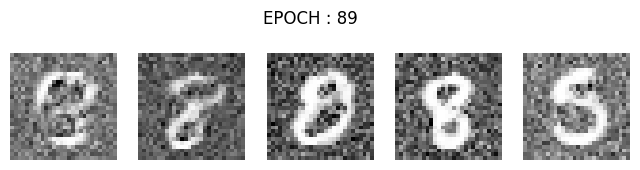

Epoch 90/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 90/100] [Batch: 938/938] [D loss: 0.1120] [G loss: 5.3440]

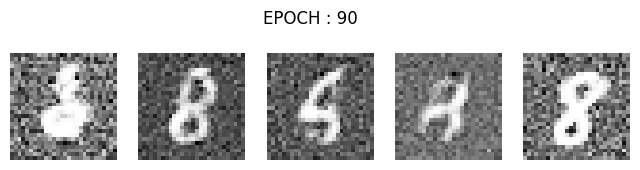

Epoch 91/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 91/100] [Batch: 938/938] [D loss: 0.1426] [G loss: 5.4916]

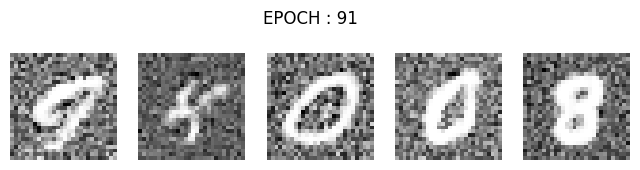

Epoch 92/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 92/100] [Batch: 938/938] [D loss: 0.0537] [G loss: 5.2996]

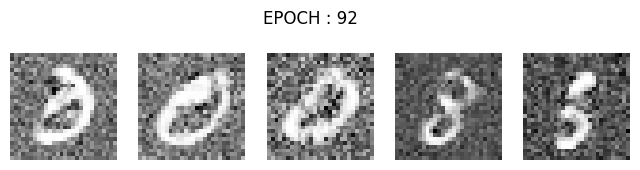

Epoch 93/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 93/100] [Batch: 938/938] [D loss: 0.1021] [G loss: 4.6366]

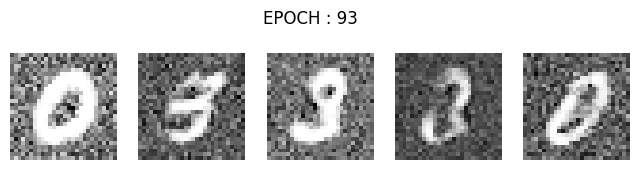

Epoch 94/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 94/100] [Batch: 938/938] [D loss: 0.1080] [G loss: 4.6991]

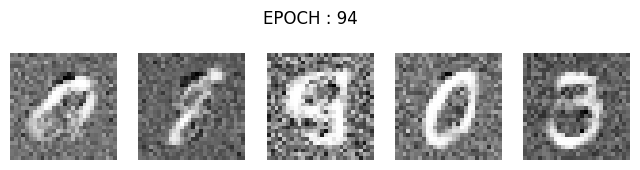

Epoch 95/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 95/100] [Batch: 938/938] [D loss: 0.0929] [G loss: 3.9397]

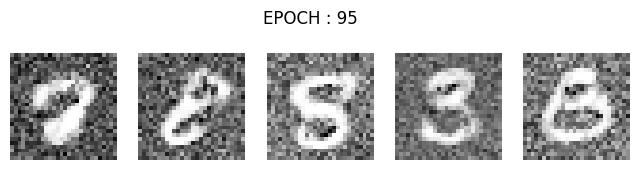

Epoch 96/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 96/100] [Batch: 938/938] [D loss: 0.1644] [G loss: 6.0080]

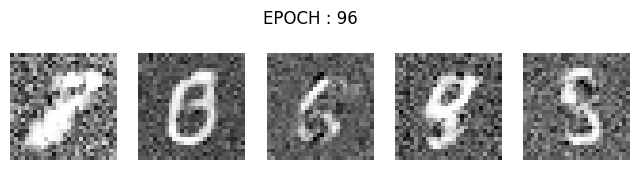

Epoch 97/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 97/100] [Batch: 938/938] [D loss: 0.1825] [G loss: 2.3998]

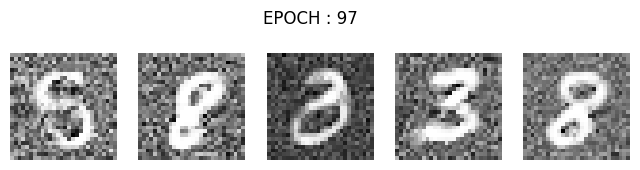

Epoch 98/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 98/100] [Batch: 938/938] [D loss: 0.1654] [G loss: 4.5650]

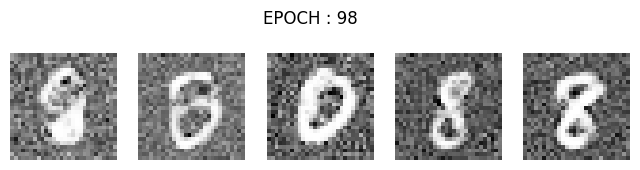

Epoch 99/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 99/100] [Batch: 938/938] [D loss: 0.1446] [G loss: 3.5577]

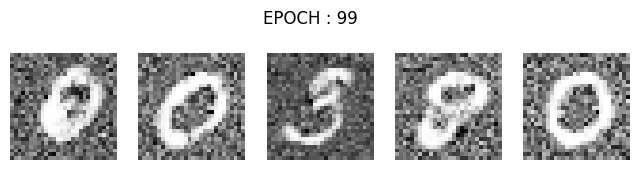

Epoch 100/100:   0%|          | 0/938 [00:00<?, ?it/s]

 [Epoch: 100/100] [Batch: 938/938] [D loss: 0.0934] [G loss: 4.9200]

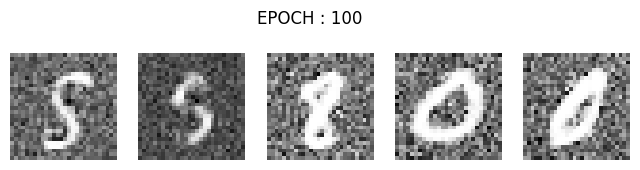

In [ ]:
n_epochs = 100 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(train_loader,desc=f'Epoch {epoch+1}/{n_epochs}')): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()


        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

        # Print losses after each batch
        tqdm.write(f"\r [Epoch: {epoch+1}/{n_epochs}] [Batch: {i+1}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]", end = '')

    # Save the model checkpoints
    torch.save(generator.state_dict(), 'generator.ckpt')
    torch.save(discriminator.state_dict(), 'discriminator.ckpt')

# ------------
# Real Time Visualization (While Training)
# ------------

    sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
    # z.shape == torch.Size([64, 100])
    sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
    # gen_imgs.shape == torch.Size([64, 1, 28, 28])

    nrow = 1
    ncols = 5
    fig, axes = plt.subplots(nrows=nrow, ncols=ncols, figsize=(8, 2))
    plt.suptitle(f'EPOCH : {epoch+1}')
    for ncol in range(ncols):
        axes[ncol].imshow(sample_gen_imgs_in_train.permute(0, 2, 3, 1)[ncol], cmap='gray')
        axes[ncol].axis('off')
    plt.show()

In [ ]:
torch.save(generator.state_dict(), 'generator_modified.pt' )

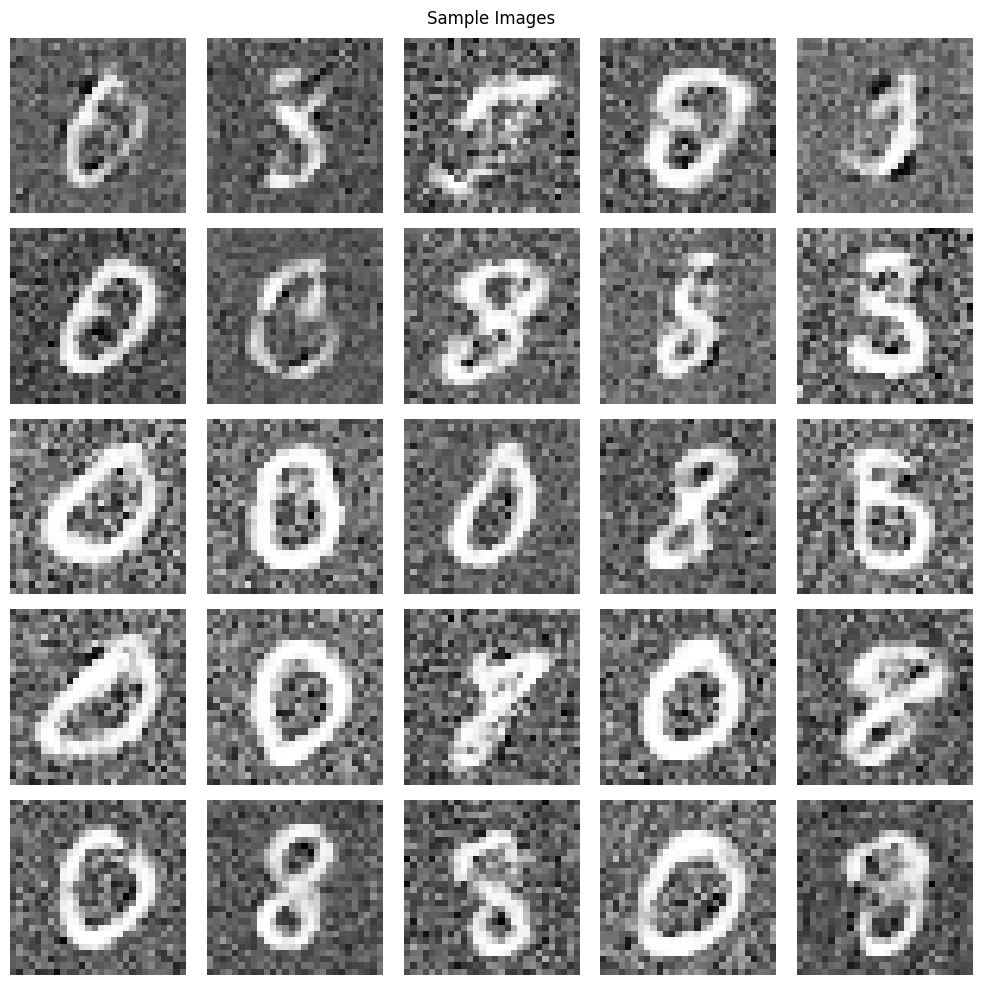

In [ ]:

model = Generator()
model.load_state_dict(torch.load('generator_modified.pt'))
model.cpu()
model.eval()

sample_z_in_train = Tensor(np.random.normal(0, 1, (64,latent_dim))).cpu()
    # z.shape == torch.Size([64, 100])
sample_gen_imgs_in_train = model(sample_z_in_train).detach().cpu()
    # gen_imgs.shape == torch.Size([64, 1, 28, 28])

nrows = 5
ncols = 5
plt.figure(figsize = (10,10))
# fig, axes = plt.sufigsize=(8, 2)bplots(nrows=nrow, ncols=ncols, )
plt.suptitle('Sample Images')
for i in range(ncols*nrows):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample_gen_imgs_in_train.permute(0, 2, 3, 1)[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()